<a href="https://colab.research.google.com/github/leonardoub/SCRIPT_PALERMO/blob/master/Classification_LDA_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [2]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


#Load data

In [3]:
#load data from Drive
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [0]:
train_dataset_path = '/gdrive/My Drive/AIM_PA/database_training2.csv'
test_dataset_path = '/gdrive/My Drive/AIM_PA/database_nostro_without_nan.csv'

In [0]:
df_train = pd.read_csv(train_dataset_path)
df_test = pd.read_csv(test_dataset_path)

In [0]:
df_train.rename(columns={'Survival.time (months)':'Surv_time_months'}, inplace=True)

In [0]:
df_test.rename(columns={'Survival.time (months)':'Surv_time_months'}, inplace=True)

In [0]:
df_train.rename(columns={'Overall.Stage':'Overall_Stage'}, inplace=True)
df_test.rename(columns={'Overall.Stage':'Overall_Stage'}, inplace=True)

In [0]:
public_data = df_train.drop(['Histology', 'Surv_time_months', 'OS', 'deadstatus.event','Overall_Stage'], axis=1)

In [0]:
PA_data = df_test.drop(['Histology', 'Surv_time_months', 'OS', 'deadstatus.event','Overall_Stage'], axis=1)

In [0]:
public_labels = df_train.Histology

In [0]:
PA_labels = df_test.Histology

#Train Test Split

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(public_data, public_labels, test_size=13, stratify=public_labels, random_state=1)

In [48]:
X_train_big.shape

(118, 107)

#Vettorizzare i label

In [0]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
train_labels_encoded = encoder.fit_transform(y_train)
test_labels_encoded = encoder.transform(y_test)

#Z score dei dati

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_data_stand = scaler.fit_transform(X_train)
test_data_stand = scaler.transform(X_test)

##LDA

In [0]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [0]:
lda = LinearDiscriminantAnalysis(n_components=3)

In [55]:
train_data_stand_lda = lda.fit_transform(train_data_stand, train_labels_encoded)

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:463: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(107, 3 - 1) = 2 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:469: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


In [56]:
train_data_stand_lda.shape

(118, 2)

In [0]:
test_data_stand_lda = lda.transform(test_data_stand)

#Z-score dopo LDA

In [0]:
from sklearn.preprocessing import StandardScaler
scaler_2 = StandardScaler()
train_data_stand_lda = scaler_2.fit_transform(train_data_stand_lda)
test_data_stand_lda = scaler_2.transform(test_data_stand_lda)

#Built classification algorithm: Nearest Neighbors

In [0]:
from sklearn.neighbors import KNeighborsClassifier


In [0]:
neigh = KNeighborsClassifier(n_neighbors=5) 

In [61]:
neigh.fit(train_data_stand_lda, train_labels_encoded)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [62]:
neigh.score(test_data_stand_lda, test_labels_encoded)

0.3076923076923077

In [47]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

y_pred = neigh.predict(test_data_stand_lda)

cm = confusion_matrix(test_labels_encoded, y_pred)
print(cm)
print('Accuracy' + str(accuracy_score(test_labels_encoded, y_pred)))

[[2 0 0]
 [1 2 3]
 [2 1 2]]
Accuracy0.46153846153846156


Text(0.5, 1.0, 'Confusion matrix Nearest Neighbors')

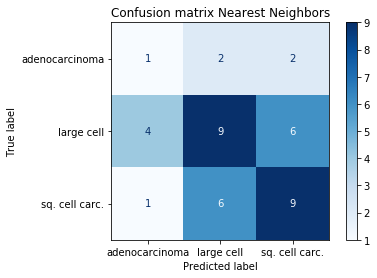

In [0]:
from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(neigh, val_data_stand_lda, y_val,
                                 display_labels=['adenocarcinoma', 'large cell', 'sq. cell carc.'], 
                                 cmap=plt.cm.Blues,
                                 normalize=None)
disp.ax_.set_title('Confusion matrix Nearest Neighbors')

##Cross Validation

In [0]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(neigh, train_data_stand_lda, y_train, cv=3)
scores

array([1., 1., 1.])

#Built classification algorithm: SVM

In [0]:
from sklearn.svm import SVC

In [0]:
clf = SVC(gamma='auto', kernel='linear', C=0.1)

In [0]:
clf.fit(train_data_stand_lda, y_train)

SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
clf.score(val_data_stand_lda, y_val)

0.475

In [0]:
clf.score(test_data_stand_lda, PA_labels)

0.2647058823529412

In [0]:
y_pred

array(['adenocarcinoma', 'squamous cell carcinoma',
       'squamous cell carcinoma', 'adenocarcinoma', 'large cell',
       'squamous cell carcinoma', 'large cell', 'squamous cell carcinoma',
       'squamous cell carcinoma', 'large cell', 'large cell',
       'large cell', 'large cell', 'squamous cell carcinoma',
       'large cell', 'large cell', 'large cell', 'adenocarcinoma',
       'adenocarcinoma', 'large cell', 'squamous cell carcinoma',
       'squamous cell carcinoma', 'squamous cell carcinoma',
       'squamous cell carcinoma', 'large cell', 'adenocarcinoma',
       'squamous cell carcinoma', 'squamous cell carcinoma',
       'squamous cell carcinoma', 'squamous cell carcinoma',
       'squamous cell carcinoma', 'large cell', 'adenocarcinoma',
       'large cell', 'large cell', 'squamous cell carcinoma',
       'large cell', 'squamous cell carcinoma', 'large cell',
       'large cell'], dtype=object)

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

y_pred = clf.predict(val_data_stand_lda)

cm = confusion_matrix(y_val, y_pred)
print(cm)
print('Accuracy' + str(accuracy_score(y_val, y_pred)))

[[1 2 2]
 [3 9 7]
 [1 6 9]]
Accuracy0.475


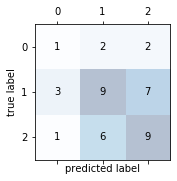

In [0]:
#matrice di confusione


fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
            ax.text(x=j,  y=i, s=cm[i, j],  va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()


Text(0.5, 1.0, 'Confusion matrix SVM')

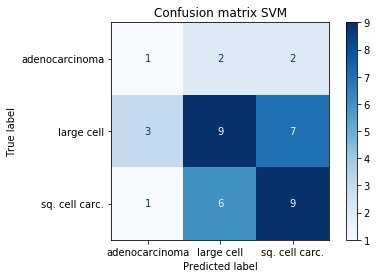

In [0]:
from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(clf, val_data_stand_lda, y_val,
                                 display_labels=['adenocarcinoma', 'large cell', 'sq. cell carc.'], 
                                 cmap=plt.cm.Blues,
                                 normalize=None)
disp.ax_.set_title('Confusion matrix SVM')

##Cross Validation

In [0]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, train_data_stand_lda, y_train, cv=3)
scores

array([1., 1., 1.])